### Introduction

#### Importing necessary libraries

In [2]:
#Importing necessary libraries
%matplotlib inline
import matplotlib as mpl
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
import pandas as pd
import numpy as np
import glob
import os
import time
import sys
import category_encoders as ce
#Various sklearn utilities and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.externals import joblib
from sklearn.ensemble import GradientBoostingRegressor
from yellowbrick.regressor import PredictionError, ResidualsPlot

#### Getting local directory and loading data

In [3]:
#Get current working directory
cwd = os.getcwd()
#Read energy simulation results
Results = pd.read_csv(cwd + "\\Energy_Results.csv")

In [4]:
Results.head(5)

,ClimateZone,Orientation,WWR,GlazingType,SHGC,OverhangLength,HVAC,HeatRecovery,Cooling,Heating,...,AverageMRT,MinMRT,MaxMRT,AverageRH,MinRH,MaxRH,PeakCoolingLoad,PeakHeatingLoad,CoolingSizing,HeatingSizing
0,1,Core,20,DP,0.2,0.5,11,1,311.812896,20.883695,...,24.005318,22.196365,24.608786,52.766281,11.492039,81.201879,549.9763,0.0,632.47274,0.0
1,1,Core,20,DP,0.2,0.5,11,2,300.340893,0.626567,...,24.005314,22.196309,24.608843,52.423143,12.634105,81.096689,549.9763,0.0,632.47274,0.0
2,1,Core,20,DP,0.2,0.5,16,0,721.700049,301.654383,...,24.274933,23.090055,25.423161,54.297460,12.561028,78.194042,549.9763,0.0,632.47274,0.0
3,1,Core,20,DP,0.2,0.5,16,1,710.907858,138.222897,...,24.274645,23.088821,25.422741,54.407838,12.591474,78.193935,549.9763,0.0,632.47274,0.0
4,1,Core,20,DP,0.2,0.5,16,2,694.776674,79.718053,...,24.274726,23.088366,25.423729,54.590228,13.629492,78.255193,549.9763,0.0,632.47274,0.0


### Data Preprocessing

#### Check unique values of categorical variables

In [5]:
#Check unique values of categorical variables
print(Results['Orientation'].unique())
print(Results['GlazingType'].unique())
print(Results['HVAC'].unique())

['Core' 'East' 'North' 'South' 'West']
['DP' 'TP']
[11 16  7]


#### Turn categorical variables to numeric labels

In [6]:
#Label encoding of categorical features

ORLabel = LabelEncoder()
orientation_labels = ORLabel.fit_transform(Results['Orientation'])
orientation_mapping = {index: label for index, label in enumerate(ORLabel.classes_)}
print("Orientation label mapping:", orientation_mapping)
Results['Orientation'] = orientation_labels

glzLabel = LabelEncoder()
glazing_labels = glzLabel.fit_transform(Results['GlazingType'])
glz_mapping = {index: label for index, label in enumerate(glzLabel.classes_)}
print("Glazing Type label mapping:", glz_mapping)
Results['GlazingType'] = glazing_labels

hvacLabel = LabelEncoder()
hvac_labels = hvacLabel.fit_transform(Results['HVAC'])
hvac_mapping = {index: label for index, label in enumerate(hvacLabel.classes_)}
print("HVAC Type label mapping:", hvac_mapping)
Results['HVAC'] = hvac_labels

X = Results.iloc[:, :8]
y = Results.iloc[:, 8] + Results.iloc[:, 9] + Results.iloc[:, 10] + Results.iloc[:, 11] + Results.iloc[:, 12]

Orientation label mapping: {0: 'Core', 1: 'East', 2: 'North', 3: 'South', 4: 'West'}
Glazing Type label mapping: {0: 'DP', 1: 'TP'}
HVAC Type label mapping: {0: 7, 1: 11, 2: 16}


In [7]:
Results.head()

,ClimateZone,Orientation,WWR,GlazingType,SHGC,OverhangLength,HVAC,HeatRecovery,Cooling,Heating,...,AverageMRT,MinMRT,MaxMRT,AverageRH,MinRH,MaxRH,PeakCoolingLoad,PeakHeatingLoad,CoolingSizing,HeatingSizing
0,1,0,20,0,0.2,0.5,1,1,311.812896,20.883695,...,24.005318,22.196365,24.608786,52.766281,11.492039,81.201879,549.9763,0.0,632.47274,0.0
1,1,0,20,0,0.2,0.5,1,2,300.340893,0.626567,...,24.005314,22.196309,24.608843,52.423143,12.634105,81.096689,549.9763,0.0,632.47274,0.0
2,1,0,20,0,0.2,0.5,2,0,721.700049,301.654383,...,24.274933,23.090055,25.423161,54.297460,12.561028,78.194042,549.9763,0.0,632.47274,0.0
3,1,0,20,0,0.2,0.5,2,1,710.907858,138.222897,...,24.274645,23.088821,25.422741,54.407838,12.591474,78.193935,549.9763,0.0,632.47274,0.0
4,1,0,20,0,0.2,0.5,2,2,694.776674,79.718053,...,24.274726,23.088366,25.423729,54.590228,13.629492,78.255193,549.9763,0.0,632.47274,0.0


In [8]:
Results.iloc[:,:13].head()

,ClimateZone,Orientation,WWR,GlazingType,SHGC,OverhangLength,HVAC,HeatRecovery,Cooling,Heating,Lighting,Fans,Pumps
0,1,0,20,0,0.2,0.5,1,1,311.812896,20.883695,612.913717,58.941109,92.912378
1,1,0,20,0,0.2,0.5,1,2,300.340893,0.626567,612.913717,58.863011,92.166292
2,1,0,20,0,0.2,0.5,2,0,721.700049,301.654383,612.913717,267.528228,46.442213
3,1,0,20,0,0.2,0.5,2,1,710.907858,138.222897,612.913717,267.528228,34.807325
4,1,0,20,0,0.2,0.5,2,2,694.776674,79.718053,612.913717,267.528228,28.000885


Notice how we aren't doing any scaling of the target variable

### Train a Gradient Boosting Regressor on all categorical encodings

#### Binary encoding

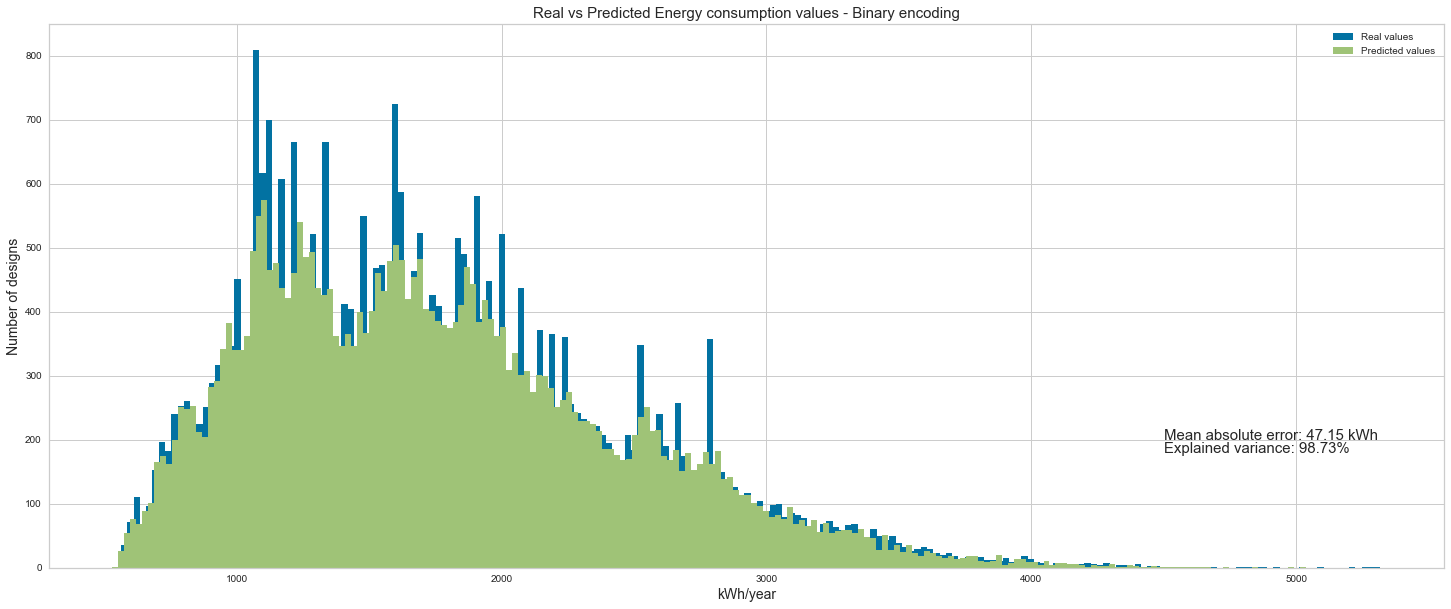

In [10]:
#Instance the model
grdBoosting_bin = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None, learning_rate=0.05, loss='ls', 
                                            max_depth=10, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                            min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, 
                                            min_weight_fraction_leaf=0.0, n_estimators=5000, presort='auto', 
                                            random_state=1337, subsample=1.0, verbose=0, warm_start=False)

#Split into stratified trainging and testing datasets, according to selected feature
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=1000, 
                                                    shuffle=True, stratify=X['ClimateZone'])

#Encode training and testing splits
binary = ce.BinaryEncoder(verbose=1, drop_invariant=True, 
                          cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
X_train = binary.transform(X_train)
X_test = binary.transform(X_test)

#Flatten target arrays
y_train = y_train.ravel().astype('float32')
y_test = y_test.ravel().astype('float32')
"""
#Scale results
scalerX = StandardScaler()
scalery = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)
y_train = scalery.fit_transform(y_train.values.reshape(-1,1))
y_test = scalery.transform(y_test.values.reshape(-1,1))
"""

#Fit the model and plot results
grdBoosting_bin.fit(X_train,y_train)
y_pred = grdBoosting_bin.predict(X_test)
#y_pred = scalery.inverse_transform(y_pred)
#y_test = scalery.inverse_transform(y_test)
plt.figure(figsize=(25,10))
plt.hist(y_test, bins=200, label='Real values')
plt.hist(y_pred, bins=200, label='Predicted values')
plt.title('Real vs Predicted Energy consumption values - Binary encoding', fontsize=15)
plt.text(4500, 200, ("Mean absolute error: %.2f kWh" % mean_absolute_error(y_test, y_pred)), fontsize=15)
plt.text(4500, 180, ("Explained variance:" + "{: .2%}".format(r2_score(y_test, y_pred))), fontsize=15)
plt.xlabel('kWh/year', fontsize=14)
plt.ylabel('Number of designs', fontsize=14)
plt.legend(loc='upper right')
plt.savefig("Binary_encoding.png", dpi=200)
plt.show()

#### Backward differencing encoding

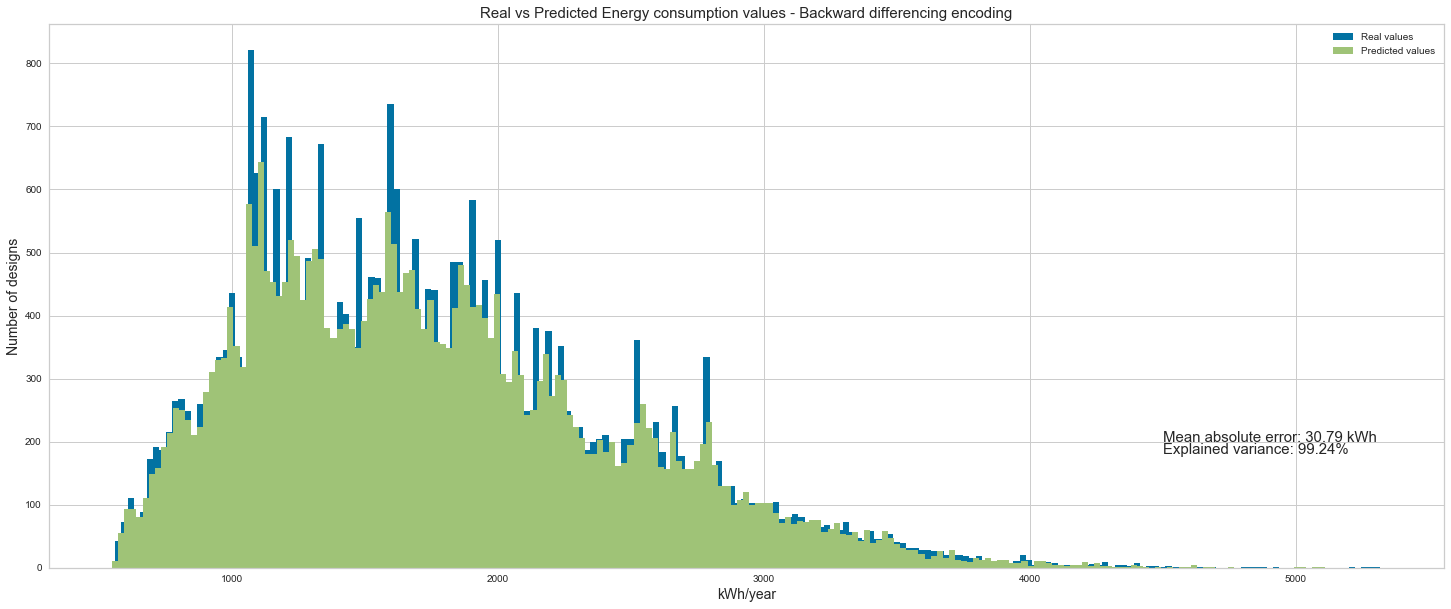

In [11]:
grdBoosting_bd = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None, learning_rate=0.05, loss='ls', 
                                            max_depth=10, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                            min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, 
                                            min_weight_fraction_leaf=0.0, n_estimators=5000, presort='auto', 
                                            random_state=1337, subsample=1.0, verbose=0, warm_start=False)

#Split into stratified trainging and testing datasets, according to selected feature
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=2000, 
                                                    shuffle=True, stratify=X['ClimateZone'])

#Encode training and testing splits
backward = ce.BackwardDifferenceEncoder(verbose=1, drop_invariant=True, 
                                        cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
X_train = backward.transform(X_train)
X_test = backward.transform(X_test)

#Flatten target arrays
y_train = y_train.ravel().astype('float32')
y_test = y_test.ravel().astype('float32')
"""
#Scale results
scalerX = StandardScaler()
scalery = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)
y_train = scalery.fit_transform(y_train.values.reshape(-1,1))
y_test = scalery.transform(y_test.values.reshape(-1,1))
"""

grdBoosting_bd.fit(X_train,y_train)
y_pred = grdBoosting_bd.predict(X_test)
#y_pred = scalery.inverse_transform(y_pred)
#y_test = scalery.inverse_transform(y_test)
plt.figure(figsize=(25,10))
plt.hist(y_test, bins=200, label='Real values')
plt.hist(y_pred, bins=200, label='Predicted values')
plt.title('Real vs Predicted Energy consumption values - Backward differencing encoding', fontsize=15)
plt.text(4500, 200, ("Mean absolute error: %.2f kWh" % mean_absolute_error(y_test, y_pred)), fontsize=15)
plt.text(4500, 180, ("Explained variance:" + "{: .2%}".format(r2_score(y_test, y_pred))), fontsize=15)
plt.xlabel('kWh/year', fontsize=14)
plt.ylabel('Number of designs', fontsize=14)
plt.legend(loc='upper right')
plt.savefig("BackwardDifferencing_encoding.png", dpi=200)
plt.show()

#### Helmert encoding

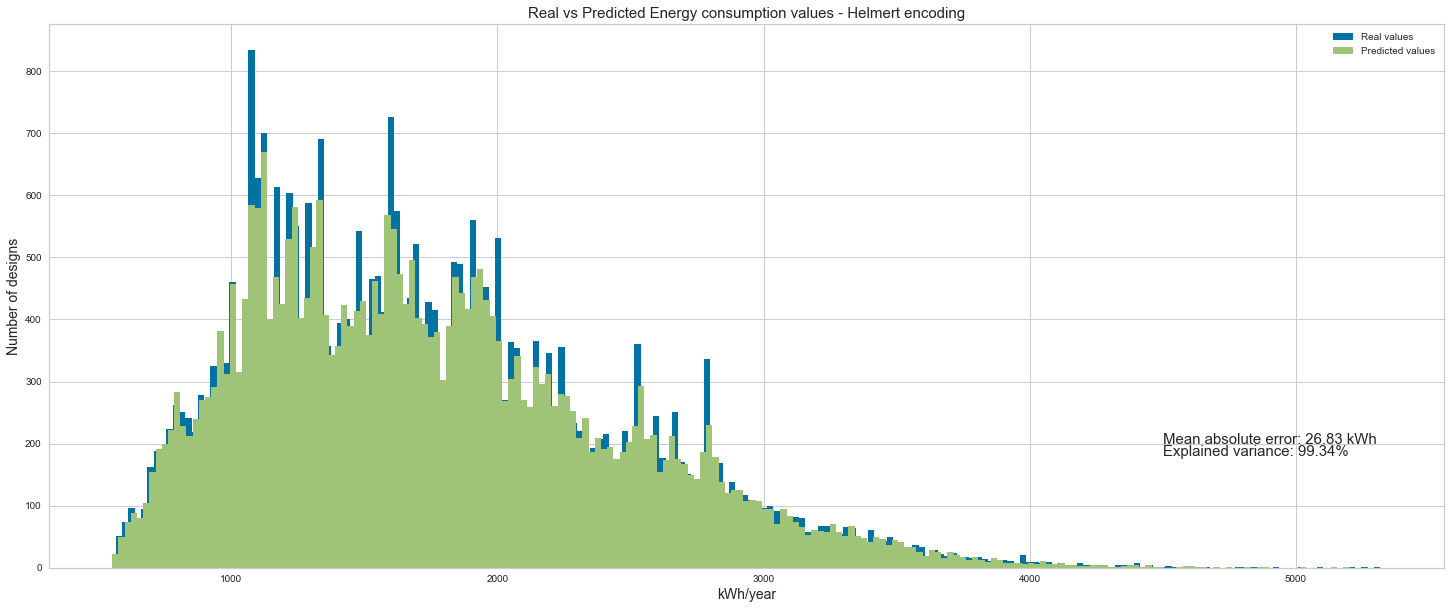

In [12]:
grdBoosting_helmert = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None, learning_rate=0.05, loss='ls', 
                                            max_depth=10, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                            min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, 
                                            min_weight_fraction_leaf=0.0, n_estimators=5000, presort='auto', 
                                            random_state=1337, subsample=1.0, verbose=0, warm_start=False)

#Split into stratified trainging and testing datasets, according to selected feature
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=3000, 
                                                    shuffle=True, stratify=X['ClimateZone'])

#Encode training and testing splits
helmert = ce.HelmertEncoder(verbose=1, drop_invariant=True, 
                            cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
X_train = helmert.transform(X_train)
X_test = helmert.transform(X_test)

#Flatten target arrays
y_train = y_train.ravel().astype('float32')
y_test = y_test.ravel().astype('float32')
"""
#Scale results
scalerX = StandardScaler()
scalery = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)
y_train = scalery.fit_transform(y_train.values.reshape(-1,1))
y_test = scalery.transform(y_test.values.reshape(-1,1))
"""

grdBoosting_helmert.fit(X_train,y_train)
y_pred = grdBoosting_helmert.predict(X_test)
#y_pred = scalery.inverse_transform(y_pred)
#y_test = scalery.inverse_transform(y_test)
plt.figure(figsize=(25,10))
plt.hist(y_test, bins=200, label='Real values')
plt.hist(y_pred, bins=200, label='Predicted values')
plt.title('Real vs Predicted Energy consumption values - Helmert encoding', fontsize=15)
plt.text(4500, 200, ("Mean absolute error: %.2f kWh" % mean_absolute_error(y_test, y_pred)), fontsize=15)
plt.text(4500, 180, ("Explained variance:" + "{: .2%}".format(r2_score(y_test, y_pred))), fontsize=15)
plt.xlabel('kWh/year', fontsize=14)
plt.ylabel('Number of designs', fontsize=14)
plt.legend(loc='upper right')
plt.savefig("Helmert_encoding.png", dpi=200)
plt.show()

#### Leave one out encoding

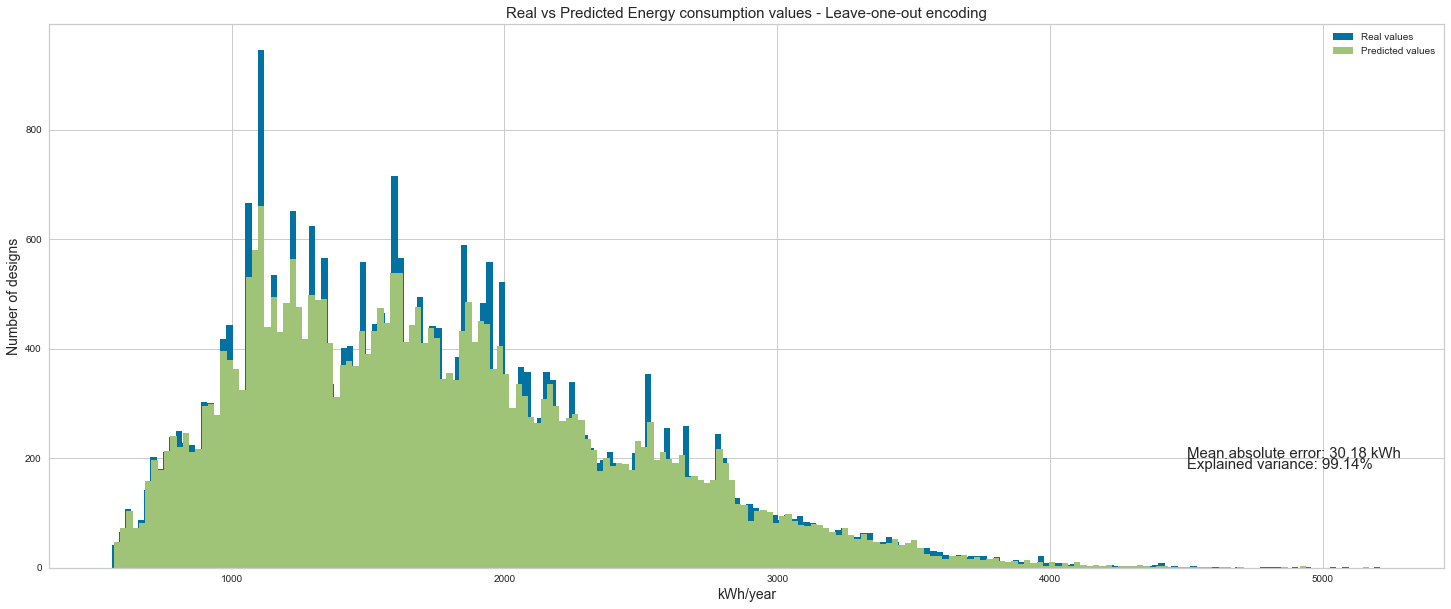

In [13]:
grdBoosting_lou = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None, learning_rate=0.05, loss='ls', 
                                            max_depth=10, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                            min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, 
                                            min_weight_fraction_leaf=0.0, n_estimators=5000, presort='auto', 
                                            random_state=1337, subsample=1.0, verbose=0, warm_start=False)

#Split into stratified trainging and testing datasets, according to selected feature
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=4000, 
                                                    shuffle=True, stratify=X['ClimateZone'])

#Encode training and testing splits
lou = ce.LeaveOneOutEncoder(verbose=1, drop_invariant=True, 
                            cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
X_train = lou.transform(X_train)
X_test = lou.transform(X_test)

#Flatten target arrays
y_train = y_train.ravel().astype('float32')
y_test = y_test.ravel().astype('float32')
"""
#Scale results
scalerX = StandardScaler()
scalery = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)
y_train = scalery.fit_transform(y_train.values.reshape(-1,1))
y_test = scalery.transform(y_test.values.reshape(-1,1))
"""

grdBoosting_lou.fit(X_train,y_train)
y_pred = grdBoosting_lou.predict(X_test)
#y_pred = scalery.inverse_transform(y_pred)
#y_test = scalery.inverse_transform(y_test)
plt.figure(figsize=(25,10))
plt.hist(y_test, bins=200, label='Real values')
plt.hist(y_pred, bins=200, label='Predicted values')
plt.title('Real vs Predicted Energy consumption values - Leave-one-out encoding', fontsize=15)
plt.text(4500, 200, ("Mean absolute error: %.2f kWh" % mean_absolute_error(y_test, y_pred)), fontsize=15)
plt.text(4500, 180, ("Explained variance:" + "{: .2%}".format(r2_score(y_test, y_pred))), fontsize=15)
plt.xlabel('kWh/year', fontsize=14)
plt.ylabel('Number of designs', fontsize=14)
plt.legend(loc='upper right')
plt.savefig("LeaveOneOut_encoding.png", dpi=200)
plt.show()

#### One hot encoding

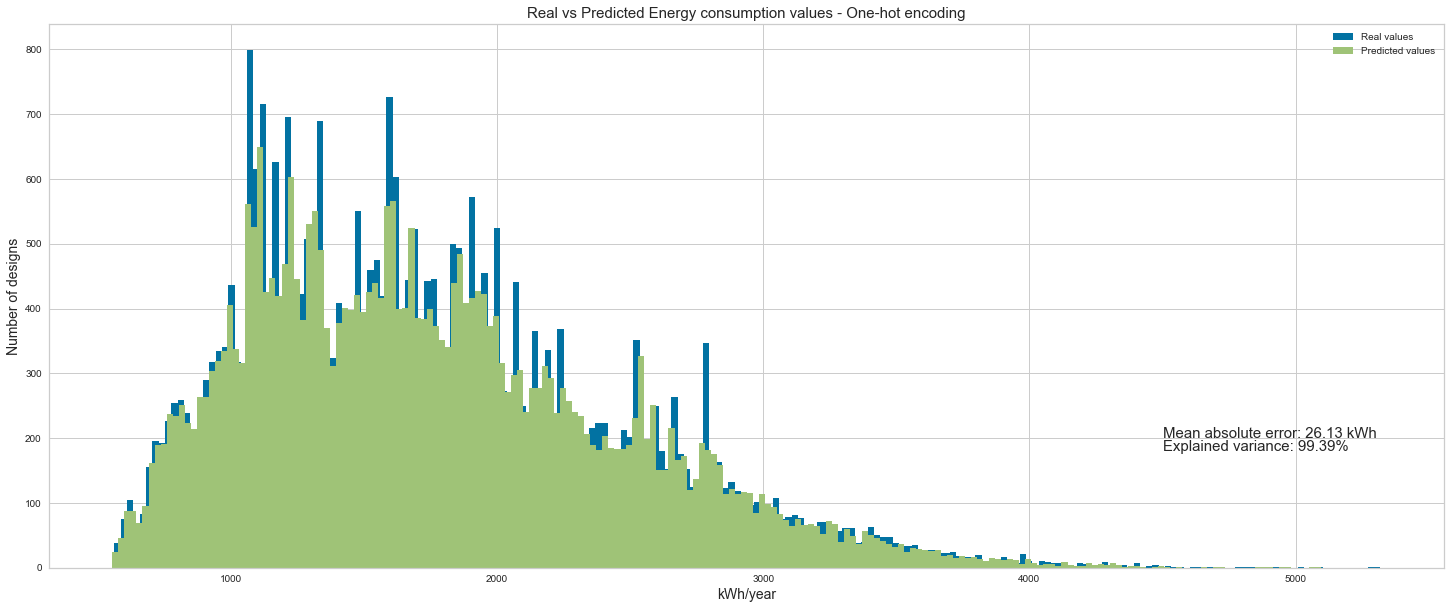

In [14]:
grdBoosting_onh = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None, learning_rate=0.05, loss='ls', 
                                            max_depth=10, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                            min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, 
                                            min_weight_fraction_leaf=0.0, n_estimators=5000, presort='auto', 
                                            random_state=1337, subsample=1.0, verbose=0, warm_start=False)

#Split into stratified trainging and testing datasets, according to selected feature
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=5000, 
                                                    shuffle=True, stratify=X['ClimateZone'])

#Encode training and testing splits
oneHot = ce.OneHotEncoder(verbose=1, drop_invariant=True, 
                          cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
X_train = oneHot.transform(X_train)
X_test = oneHot.transform(X_test)

#Flatten target arrays
y_train = y_train.ravel().astype('float32')
y_test = y_test.ravel().astype('float32')
"""
#Scale results
scalerX = StandardScaler()
scalery = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)
y_train = scalery.fit_transform(y_train.values.reshape(-1,1))
y_test = scalery.transform(y_test.values.reshape(-1,1))
"""

grdBoosting_onh.fit(X_train,y_train)
y_pred = grdBoosting_onh.predict(X_test)
#y_pred = scalery.inverse_transform(y_pred)
#y_test = scalery.inverse_transform(y_test)
plt.figure(figsize=(25,10))
plt.hist(y_test, bins=200, label='Real values')
plt.hist(y_pred, bins=200, label='Predicted values')
plt.title('Real vs Predicted Energy consumption values - One-hot encoding', fontsize=15)
plt.text(4500, 200, ("Mean absolute error: %.2f kWh" % mean_absolute_error(y_test, y_pred)), fontsize=15)
plt.text(4500, 180, ("Explained variance:" + "{: .2%}".format(r2_score(y_test, y_pred))), fontsize=15)
plt.xlabel('kWh/year', fontsize=14)
plt.ylabel('Number of designs', fontsize=14)
plt.legend(loc='upper right')
plt.savefig("OneHot_encoding.png", dpi=200)
plt.show()

#### Ordinal encoding

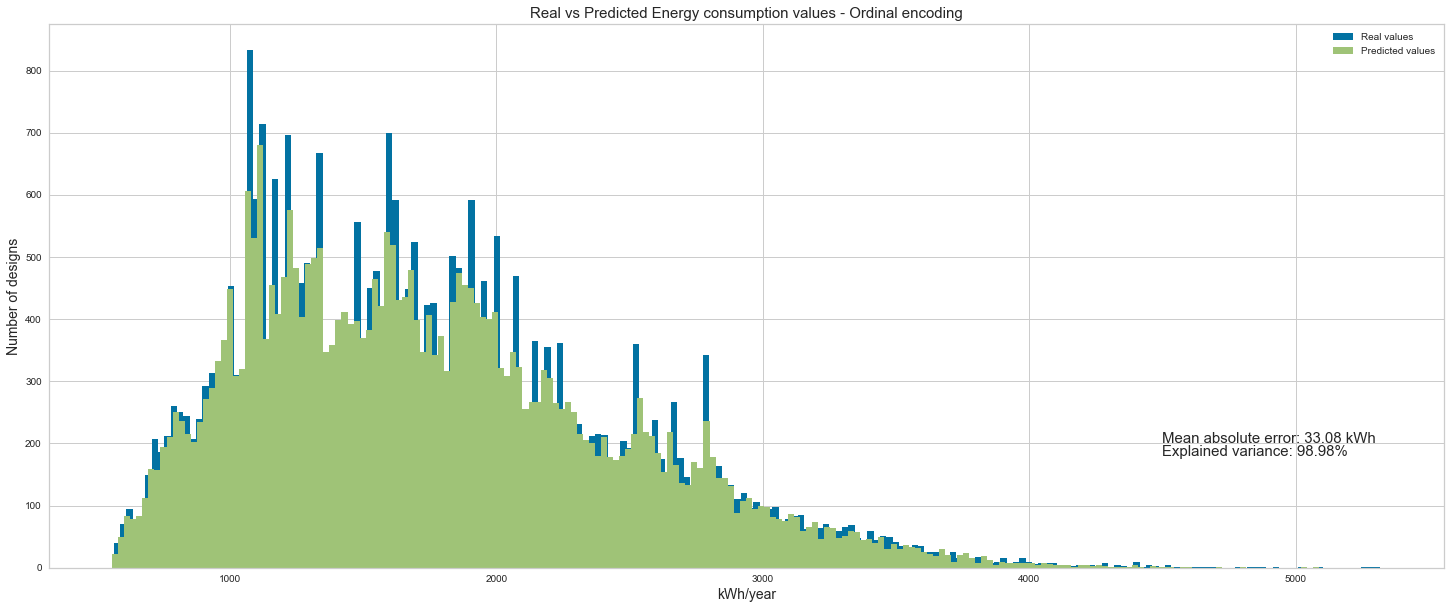

In [15]:
grdBoosting_ord = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None, learning_rate=0.05, loss='ls', 
                                            max_depth=10, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                            min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, 
                                            min_weight_fraction_leaf=0.0, n_estimators=5000, presort='auto', 
                                            random_state=1337, subsample=1.0, verbose=0, warm_start=False)

#Split into stratified trainging and testing datasets, according to selected feature
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=6000, 
                                                    shuffle=True, stratify=X['ClimateZone'])

#Encode training and testing splits
ordinal = ce.OrdinalEncoder(verbose=1, drop_invariant=True, 
                            cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
X_train = ordinal.transform(X_train)
X_test = ordinal.transform(X_test)

#Flatten target arrays
y_train = y_train.ravel().astype('float32')
y_test = y_test.ravel().astype('float32')
"""
#Scale results
scalerX = StandardScaler()
scalery = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)
y_train = scalery.fit_transform(y_train.values.reshape(-1,1))
y_test = scalery.transform(y_test.values.reshape(-1,1))
"""

grdBoosting_ord.fit(X_train,y_train)
y_pred = grdBoosting_ord.predict(X_test)
#y_pred = scalery.inverse_transform(y_pred)
#y_test = scalery.inverse_transform(y_test)
plt.figure(figsize=(25,10))
plt.hist(y_test, bins=200, label='Real values')
plt.hist(y_pred, bins=200, label='Predicted values')
plt.title('Real vs Predicted Energy consumption values - Ordinal encoding', fontsize=15)
plt.text(4500, 200, ("Mean absolute error: %.2f kWh" % mean_absolute_error(y_test, y_pred)), fontsize=15)
plt.text(4500, 180, ("Explained variance:" + "{: .2%}".format(r2_score(y_test, y_pred))), fontsize=15)
plt.xlabel('kWh/year', fontsize=14)
plt.ylabel('Number of designs', fontsize=14)
plt.legend(loc='upper right')
plt.savefig("Ordinal_encoding.png", dpi=200)
plt.show()

#### Polynomial encoding

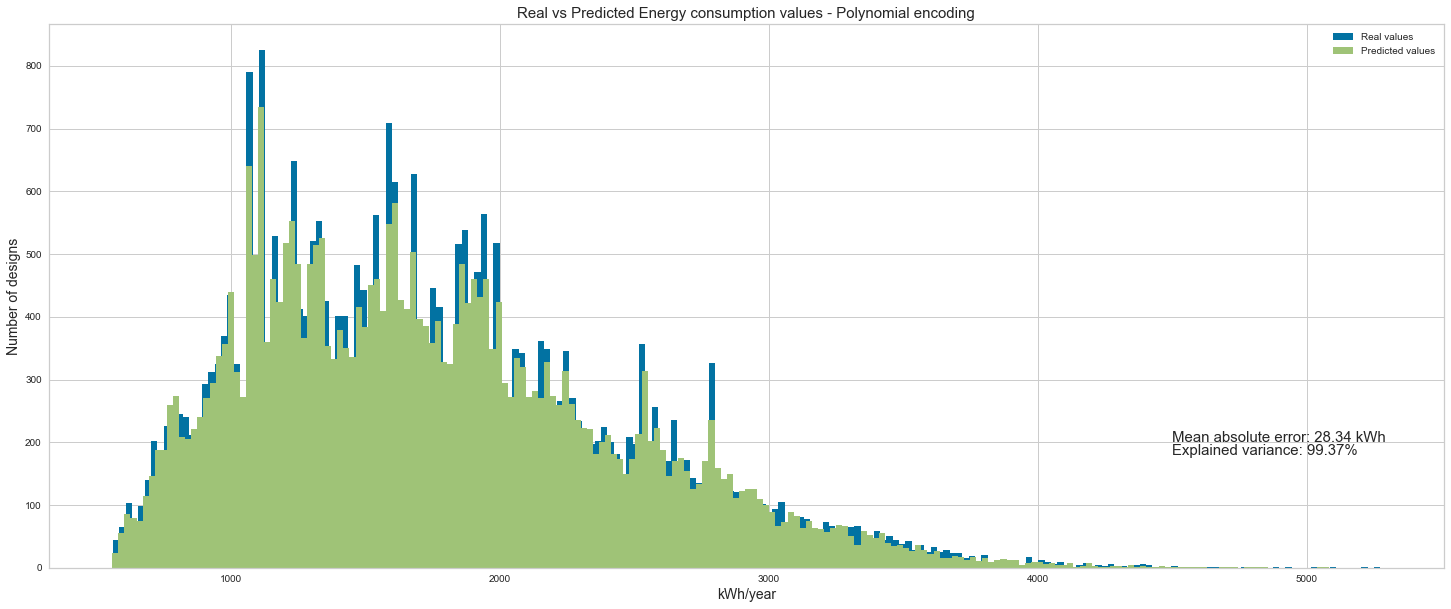

In [16]:
grdBoosting_poly = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None, learning_rate=0.05, loss='ls', 
                                            max_depth=10, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                            min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, 
                                            min_weight_fraction_leaf=0.0, n_estimators=5000, presort='auto', 
                                            random_state=1337, subsample=1.0, verbose=0, warm_start=False)

#Split into stratified trainging and testing datasets, according to selected feature
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=7000, 
                                                    shuffle=True, stratify=X['ClimateZone'])

#Encode training and testing splits
polynomial = ce.PolynomialEncoder(verbose=1, drop_invariant=True, 
                                  cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
X_train = polynomial.transform(X_train)
X_test = polynomial.transform(X_test)

#Flatten target arrays
y_train = y_train.ravel().astype('float32')
y_test = y_test.ravel().astype('float32')
"""
#Scale results
scalerX = StandardScaler()
scalery = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)
y_train = scalery.fit_transform(y_train.values.reshape(-1,1))
y_test = scalery.transform(y_test.values.reshape(-1,1))
"""

grdBoosting_poly.fit(X_train,y_train)
y_pred = grdBoosting_poly.predict(X_test)
#y_pred = scalery.inverse_transform(y_pred)
#y_test = scalery.inverse_transform(y_test)
plt.figure(figsize=(25,10))
plt.hist(y_test, bins=200, label='Real values')
plt.hist(y_pred, bins=200, label='Predicted values')
plt.title('Real vs Predicted Energy consumption values - Polynomial encoding', fontsize=15)
plt.text(4500, 200, ("Mean absolute error: %.2f kWh" % mean_absolute_error(y_test, y_pred)), fontsize=15)
plt.text(4500, 180, ("Explained variance:" + "{: .2%}".format(r2_score(y_test, y_pred))), fontsize=15)
plt.xlabel('kWh/year', fontsize=14)
plt.ylabel('Number of designs', fontsize=14)
plt.legend(loc='upper right')
plt.savefig("Polynomial_encoding.png", dpi=200)
plt.show()

#### Sum encoding

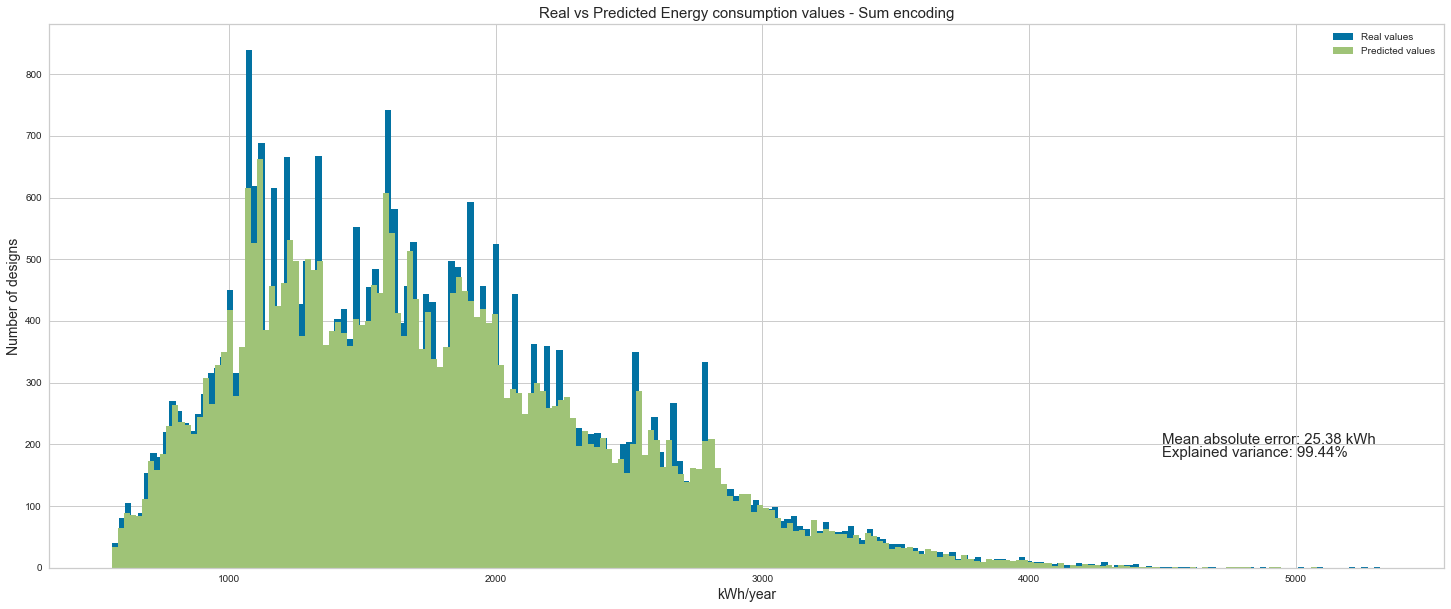

In [17]:
grdBoosting_sum = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None, learning_rate=0.05, loss='ls', 
                                            max_depth=10, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                            min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, 
                                            min_weight_fraction_leaf=0.0, n_estimators=5000, presort='auto', 
                                            random_state=1337, subsample=1.0, verbose=0, warm_start=False)

#Split into stratified trainging and testing datasets, according to selected feature
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=8000, 
                                                    shuffle=True, stratify=X['ClimateZone'])

#Encode training and testing splits
sumenc = ce.SumEncoder(verbose=1, drop_invariant=True, 
                       cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
X_train = sumenc.transform(X_train)
X_test = sumenc.transform(X_test)

#Flatten target arrays
y_train = y_train.ravel().astype('float32')
y_test = y_test.ravel().astype('float32')
"""
#Scale results
scalerX = StandardScaler()
scalery = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)
y_train = scalery.fit_transform(y_train.values.reshape(-1,1))
y_test = scalery.transform(y_test.values.reshape(-1,1))
"""

grdBoosting_sum.fit(X_train,y_train)
y_pred = grdBoosting_sum.predict(X_test)
#y_pred = scaler.inverse_transform(y_pred)
#y_test = scalery.inverse_transform(y_test)
plt.figure(figsize=(25,10))
plt.hist(y_test, bins=200, label='Real values')
plt.hist(y_pred, bins=200, label='Predicted values')
plt.title('Real vs Predicted Energy consumption values - Sum encoding', fontsize=15)
plt.text(4500, 200, ("Mean absolute error: %.2f kWh" % mean_absolute_error(y_test, y_pred)), fontsize=15)
plt.text(4500, 180, ("Explained variance:" + "{: .2%}".format(r2_score(y_test, y_pred))), fontsize=15)
plt.xlabel('kWh/year', fontsize=14)
plt.ylabel('Number of designs', fontsize=14)
plt.legend(loc='upper right')
plt.savefig("Sum_encoding.png", dpi=200)
plt.show()

### Model Stacking

#### Create the different encodings on the full dataset

In [18]:
#Generate whole dataset encodings for model stacking
#Binary encoding
Results_bin = binary.transform(X)

#Backward Difference encoding
Results_bd = backward.transform(X)

#Helmert encoding
Results_helmert = helmert.transform(X)

#One-hot-encoding
Results_onh = oneHot.transform(X)

#Ordinal encoding
Results_ord = ordinal.transform(X)

#Leave one out encoding
Results_lou = lou.transform(X)

#Polynomial encoding
Results_poly = polynomial.transform(X)

#Sum encoding
Results_sum = sumenc.transform(X)

#### Plot stacked regressor's performance

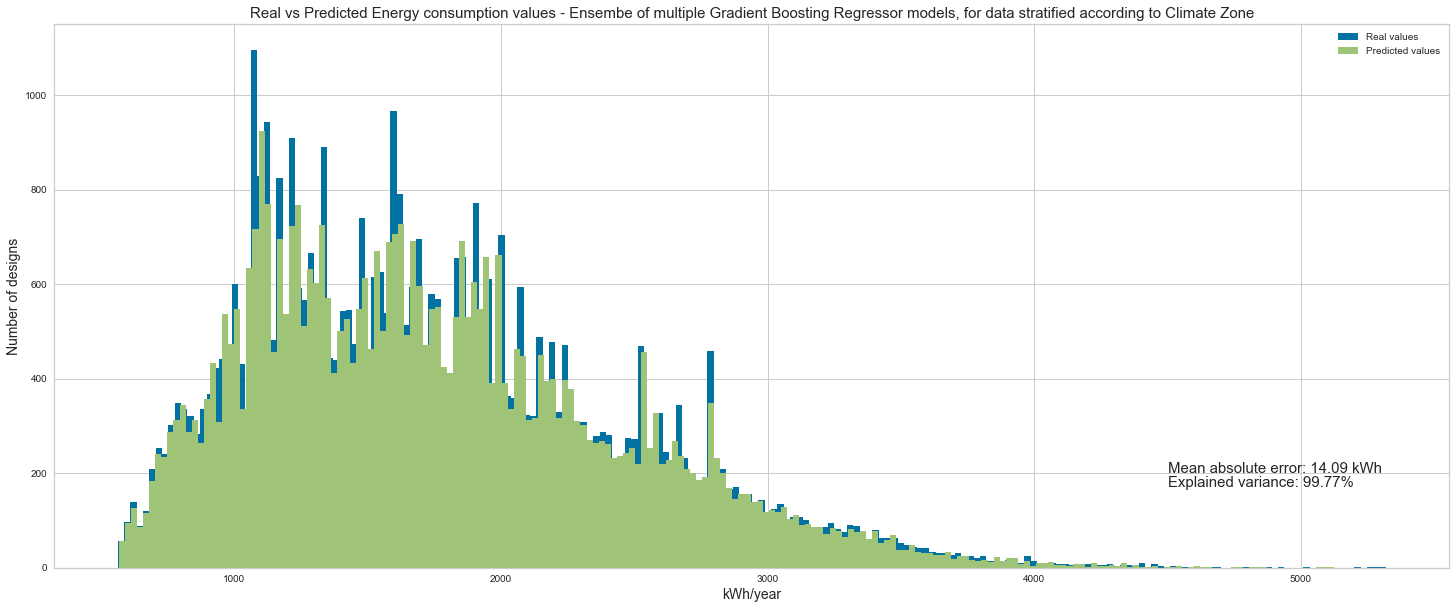

In [19]:
#Stack the results from all encodings
y_pred_GBMs = (grdBoosting_bin.predict(Results_bin) + grdBoosting_bd.predict(Results_bd) + 
               grdBoosting_helmert.predict(Results_helmert) + grdBoosting_onh.predict(Results_onh) + 
               grdBoosting_ord.predict(Results_ord) + grdBoosting_lou.predict(Results_lou) + 
               grdBoosting_poly.predict(Results_poly) + grdBoosting_sum.predict(Results_sum)) / 8

plt.figure(figsize=(25,10))
plt.hist(y, bins=200, label='Real values')
plt.hist(y_pred_GBMs, bins=200, label='Predicted values')
plt.title('Real vs Predicted Energy consumption values - Ensembe of multiple Gradient Boosting Regressor models, for data stratified according to Climate Zone', 
          fontsize=15)
plt.text(4500, 200, ("Mean absolute error: %.2f kWh" % mean_absolute_error(y, y_pred_GBMs)), fontsize=15)
plt.text(4500, 170, ("Explained variance:" + "{: .2%}".format(r2_score(y, y_pred_GBMs))), fontsize=15)
plt.xlabel('kWh/year', fontsize=14)
plt.ylabel('Number of designs', fontsize=14)
plt.legend(loc='upper right')
plt.savefig("EnsembleGBMs.png", dpi=200)
plt.show()

#### Save models to disk

Note: GBMs have a lot more parameters than the models we saw previously, so the size on disk can get large pretty fast (these are about 500-600mb each)

In [230]:
#Save predictions to disk
np.save('Predictions_GBMs', y_pred_GBMs)
#Save models to disk
joblib.dump(grdBoosting_bd, 'GBM_bd.pkl')
joblib.dump(grdBoosting_bin, 'GBM_bin.pkl')
joblib.dump(grdBoosting_helmert, 'GBM_helmert.pkl')
joblib.dump(grdBoosting_onh, 'GBM_onh.pkl')
joblib.dump(grdBoosting_ord, 'GBM_ord.pkl')
joblib.dump(grdBoosting_lou, 'GBM_lou.pkl')
joblib.dump(grdBoosting_poly, 'GBM_poly.pkl')
joblib.dump(grdBoosting_sum, 'GBM_sum.pkl')

['GBM_sum.pkl']

### High-level EDA

#### Plot the mean absolute error of some random samples

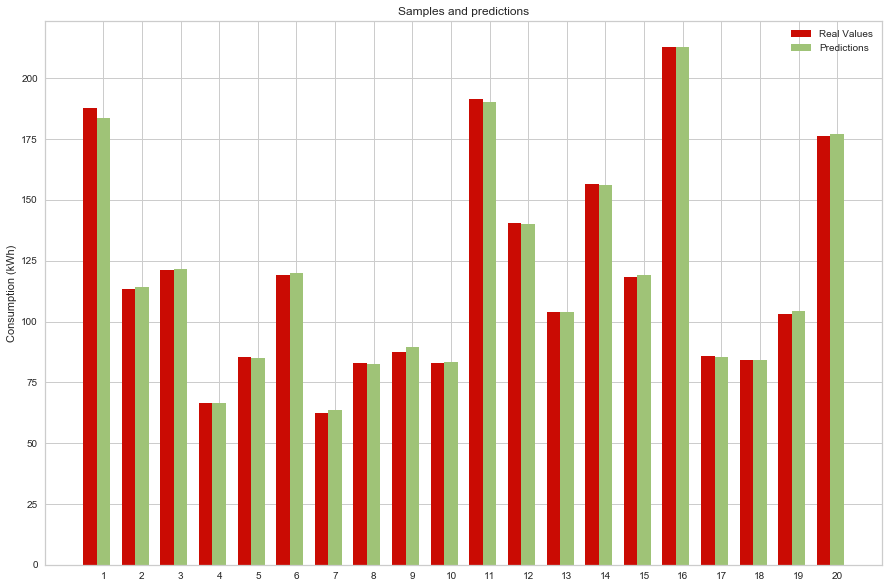

In [21]:
import numpy as np
import matplotlib.pyplot as plt

N = 20
random_models = np.random.randint(1, len(y_pred_GBMs), N)
y_samples = y[random_models] /16

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, y_samples, width, color='r')

y_predictions = y_pred_GBMs[random_models] / 16
rects2 = ax.bar(ind+width, y_predictions, width, color='g')

# add some
ax.set_ylabel('Consumption (kWh)')
ax.set_title('Samples and predictions')
ax.set_xticks(ind+width)
ax.set_xticklabels( np.arange(1,21,1) )

ax.legend( (rects1[0], rects2[0]), ('Real Values', 'Predictions') )

plt.show()

#### Save predicted results to disk, for later use

In [22]:
#Store predictions to a dataframe
predictions = pd.DataFrame(y_pred_GBMs, columns=['Predictions'])
actual = pd.DataFrame(y, columns=['Actual'])
Results_GBM = pd.concat([X, predictions, actual], axis=1)

#Save to disk
np.savetxt('Resuts_GBM.csv', Results_GBM)

#### Plot actual vs predictions for one of the features

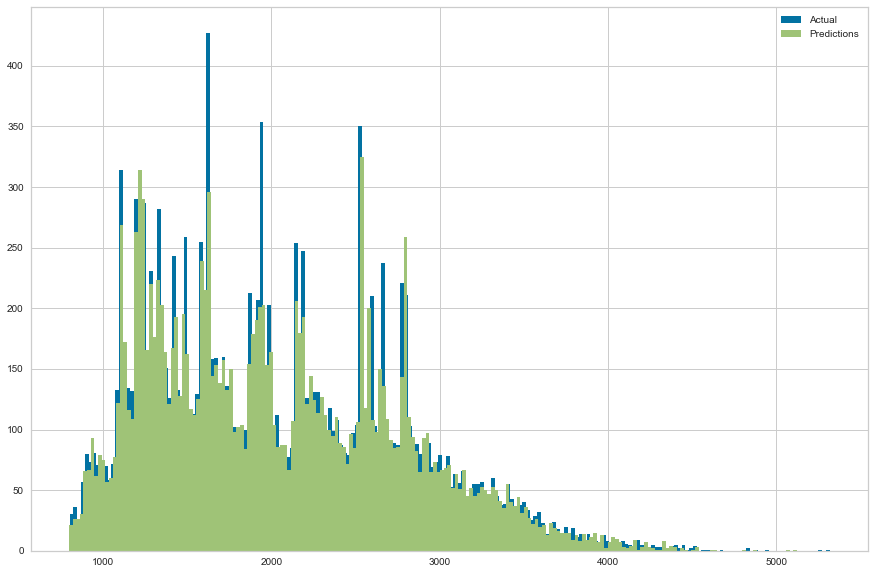

In [25]:
plt.figure(figsize=(15,10))
plt.hist(Results_GBM.loc[Results_GBM['HeatRecovery'] == 0]['Actual'], bins=200)
plt.hist(Results_GBM.loc[Results_GBM['HeatRecovery'] == 0]['Predictions'], bins=200)
rects1 = ax.bar(ind, y_samples, width, color='b')
rects2 = ax.bar(ind+width, y_predictions, width, color='g')               
plt.legend((rects1[0], rects2[0]), ('Actual', 'Predictions'))
plt.show()

#### Calculate Mean Absolute Error for each type of categorical encoding, feature and feature value

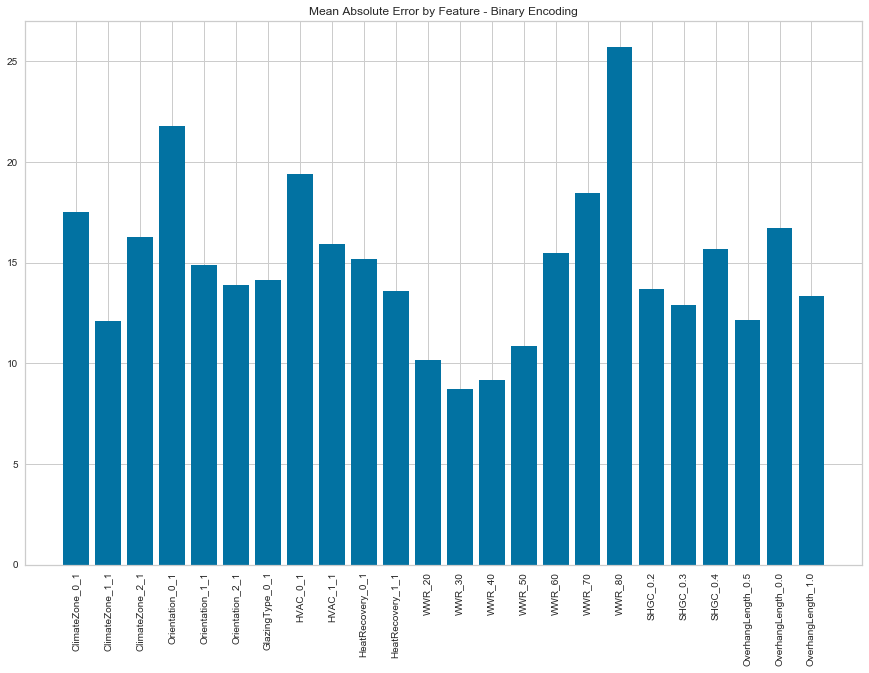

In [26]:
#Binary Encoding

#Predict across all dataset
y_pred_bin = grdBoosting_bin.predict(Results_bin)
predictions_bin = pd.DataFrame(y_pred_bin, columns=['Predictions'])
actual = pd.DataFrame(y, columns=['Actual'])
MAE_bin = pd.concat([Results_bin, predictions, actual], axis=1)

#Calculate errors per feature
features = Results_bin.columns
error = np.zeros((24,1))
values = np.zeros((24,1)).astype(str)
k = -1
for feature in features:
    j=-1
    for value in Results_bin[feature].unique():
        k+=1
        j+=1
        if((k<12) & (value == 0)):
            k-=1
        else:
            error[(k)] = mean_absolute_error(MAE_bin.loc[MAE_bin[feature] == value]['Actual'], 
                                           MAE_bin.loc[MAE_bin[feature] == value]['Predictions'])
            values[(k)] = feature + '_' + str(MAE_bin[feature].unique()[j])

# Plot MAE for each feature
plt.figure(figsize=(15,10))
plt.title("Mean Absolute Error by Feature - Binary Encoding")
plt.bar(range(values.shape[0]), error.ravel())
plt.xticks(range(values.shape[0]), values.ravel(), rotation=90)
plt.savefig('ErrorPerFeature_bin')
plt.show()

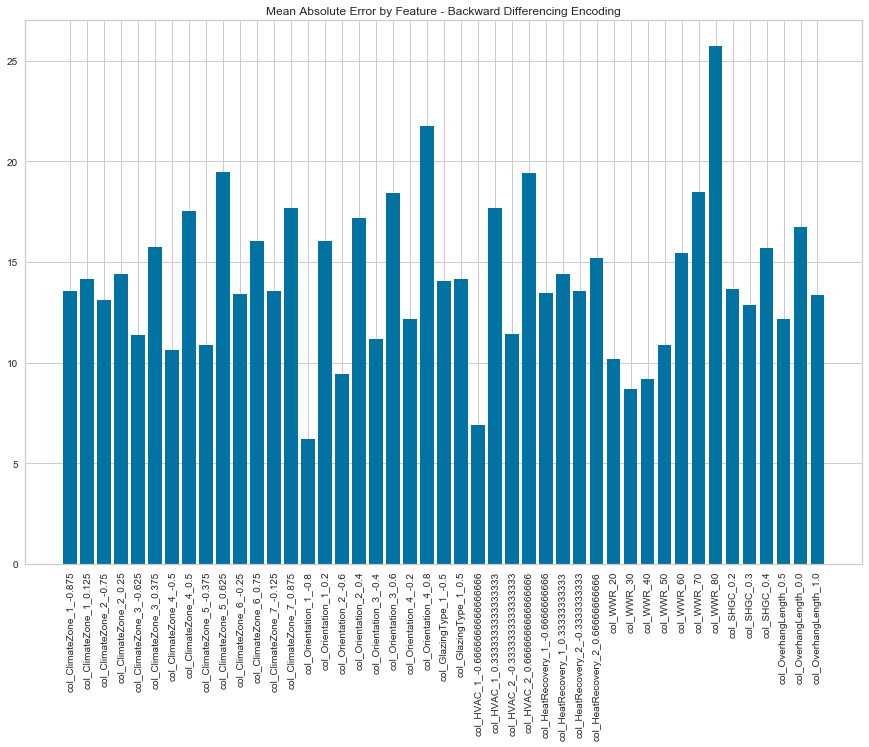

In [27]:
#Backward Differencing Encoding

#Predict across all dataset
y_pred_bd = grdBoosting_bd.predict(Results_bd)
predictions_bd = pd.DataFrame(y_pred_bd, columns=['Predictions'])
actual = pd.DataFrame(y, columns=['Actual'])
MAE_bd = pd.concat([Results_bd, predictions, actual], axis=1)

#Calculate errors per feature
features = Results_bd.columns
error = np.zeros((45,1))
values = np.zeros((45,1)).astype(str)
k = -1
for feature in features:
    j=-1
    for value in Results_bd[feature].unique():
        k+=1
        j+=1
        if((k<12) & (value == 0)):
            k-=1
        else:
            error[(k)] = mean_absolute_error(MAE_bd.loc[MAE_bd[feature] == value]['Actual'], 
                                           MAE_bd.loc[MAE_bd[feature] == value]['Predictions'])
            values[(k)] = feature + '_' + str(MAE_bd[feature].unique()[j])


# Plot MAE for each feature
plt.figure(figsize=(15,10))
plt.title("Mean Absolute Error by Feature - Backward Differencing Encoding")
plt.bar(range(values.shape[0]), error.ravel())
plt.xticks(range(values.shape[0]), values.ravel(), rotation=90)
plt.savefig('ErrorPerFeature_bd')
plt.show()

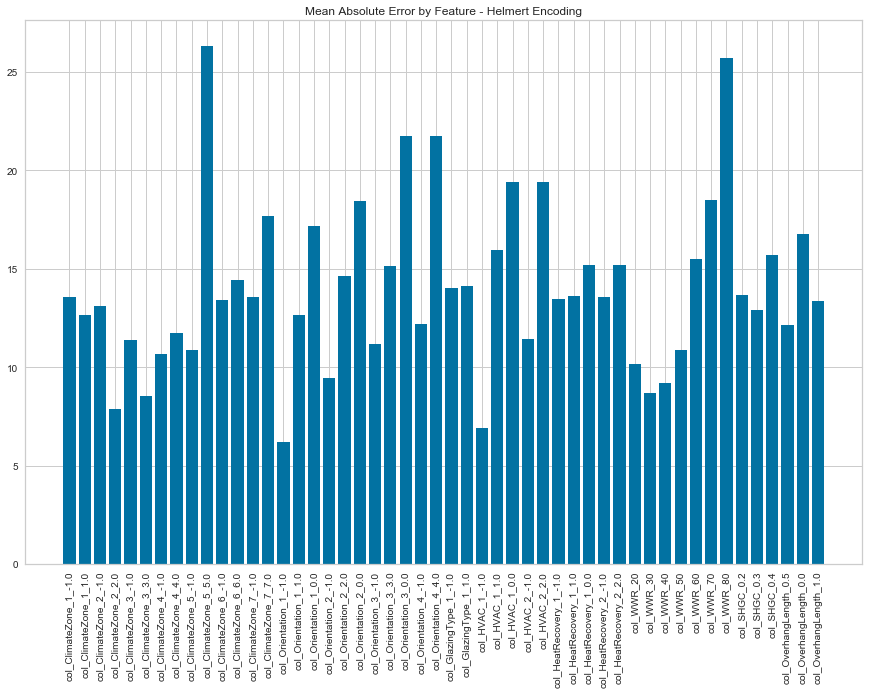

In [28]:
#Helmert Encoding

#Predict across all dataset
y_pred_helmert = grdBoosting_helmert.predict(Results_helmert)
predictions_helmert = pd.DataFrame(y_pred_helmert, columns=['Predictions'])
actual = pd.DataFrame(y, columns=['Actual'])
MAE_helmert = pd.concat([Results_helmert, predictions, actual], axis=1)

#Calculate errors per feature
features = Results_helmert.columns
error = np.zeros((50,1))
values = np.zeros((50,1)).astype(str)
k = -1
for feature in features:
    j=-1
    for value in Results_helmert[feature].unique():
        k+=1
        j+=1
        if((k<16) & (value == 0)):
            k-=1
        else:
            error[(k)] = mean_absolute_error(MAE_helmert.loc[MAE_helmert[feature] == value]['Actual'], 
                                           MAE_helmert.loc[MAE_helmert[feature] == value]['Predictions'])
            values[(k)] = feature + '_' + str(MAE_helmert[feature].unique()[j])


# Plot MAE for each feature
plt.figure(figsize=(15,10))
plt.title("Mean Absolute Error by Feature - Helmert Encoding")
plt.bar(range(values.shape[0]), error.ravel())
plt.xticks(range(values.shape[0]), values.ravel(), rotation=90)
plt.savefig('ErrorPerFeature_helmert')
plt.show()

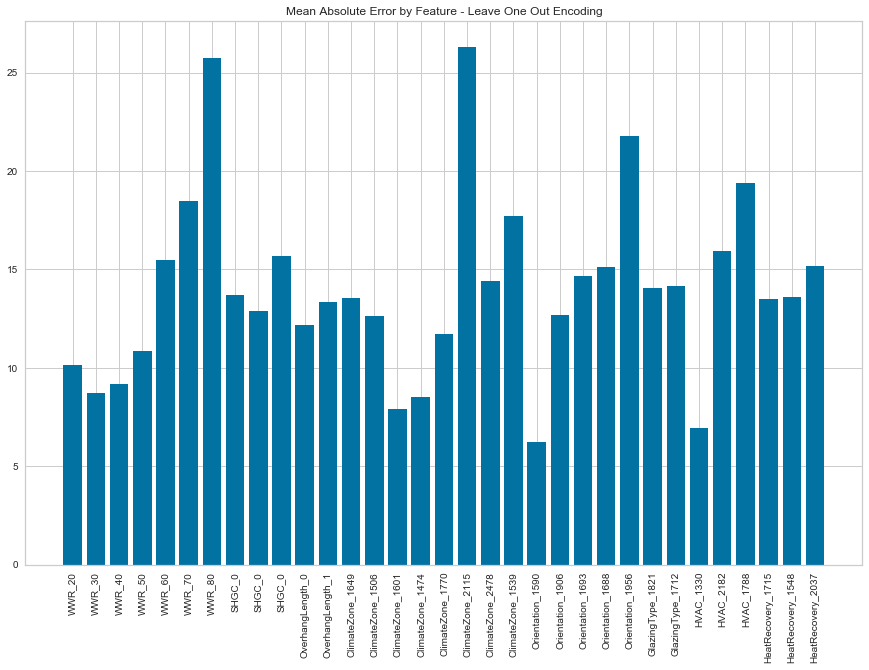

In [29]:
#Leave One Out Encoding

#Predict across all dataset
y_pred_lou = grdBoosting_lou.predict(Results_lou)
predictions_lou = pd.DataFrame(y_pred_lou, columns=['Predictions'])
actual = pd.DataFrame(y, columns=['Actual'])
MAE_lou = pd.concat([Results_lou, predictions, actual], axis=1)

#Calculate errors per feature
features = Results_lou.columns
error = np.zeros((33,1))
values = np.zeros((33,1)).astype(str)
k = -1
for feature in features:
    j=-1
    for value in Results_lou[feature].unique():
        k+=1
        j+=1
        if((k<16) & (value == 0)):
            k-=1
        else:
            error[(k)] = mean_absolute_error(MAE_lou.loc[MAE_lou[feature] == value]['Actual'], 
                                           MAE_lou.loc[MAE_lou[feature] == value]['Predictions'])
            values[(k)] = feature + '_' + str(int(MAE_lou[feature].unique()[j]))


# Plot MAE for each feature
plt.figure(figsize=(15,10))
plt.title("Mean Absolute Error by Feature - Leave One Out Encoding")
plt.bar(range(values.shape[0]), error.ravel())
plt.xticks(range(values.shape[0]), values.ravel(), rotation=90)
plt.savefig('ErrorPerFeature_lou')
plt.show()

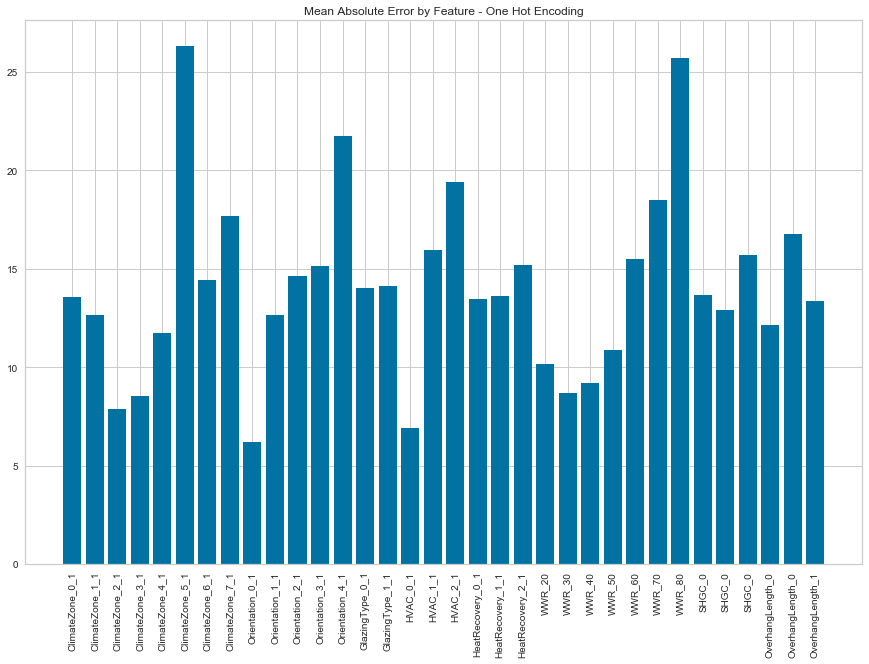

In [30]:
#One Hot Encoding

#Predict across all dataset
y_pred_onh = grdBoosting_onh.predict(Results_onh)
predictions_onh = pd.DataFrame(y_pred_onh, columns=['Predictions'])
actual = pd.DataFrame(y, columns=['Actual'])
MAE_onh = pd.concat([Results_onh, predictions, actual], axis=1)

#Calculate errors per feature
features = Results_onh.columns
error = np.zeros((34,1))
values = np.zeros((34,1)).astype(str)
k = -1
for feature in features:
    j=-1
    for value in Results_onh[feature].unique():
        k+=1
        j+=1
        if((k<21) & (value == 0)):
            k-=1
        else:
            error[(k)] = mean_absolute_error(MAE_onh.loc[MAE_onh[feature] == value]['Actual'], 
                                           MAE_onh.loc[MAE_onh[feature] == value]['Predictions'])
            values[(k)] = feature + '_' + str(int(MAE_onh[feature].unique()[j]))


# Plot MAE for each feature
plt.figure(figsize=(15,10))
plt.title("Mean Absolute Error by Feature - One Hot Encoding")
plt.bar(range(values.shape[0]), error.ravel())
plt.xticks(range(values.shape[0]), values.ravel(), rotation=90)
plt.savefig('ErrorPerFeature_onh')
plt.show()

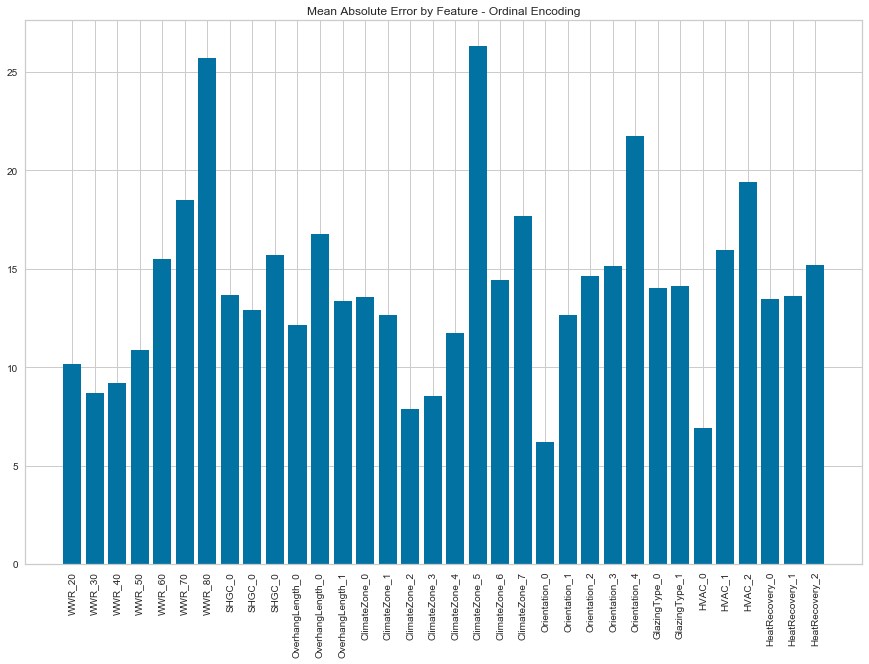

In [31]:
#Ordinal Encoding

#Predict across all dataset
y_pred_ord = grdBoosting_ord.predict(Results_ord)
predictions_ord = pd.DataFrame(y_pred_ord, columns=['Predictions'])
actual = pd.DataFrame(y, columns=['Actual'])
MAE_ord = pd.concat([Results_ord, predictions, actual], axis=1)

#Calculate errors per feature
features = Results_ord.columns
error = np.zeros((34,1))
values = np.zeros((34,1)).astype(str)
k = -1
for feature in features:
    j=-1
    for value in Results_ord[feature].unique():
        k+=1
        j+=1
        error[(k)] = mean_absolute_error(MAE_ord.loc[MAE_ord[feature] == value]['Actual'], 
                                           MAE_ord.loc[MAE_ord[feature] == value]['Predictions'])
        values[(k)] = feature + '_' + str(int(MAE_ord[feature].unique()[j]))


# Plot MAE for each feature
plt.figure(figsize=(15,10))
plt.title("Mean Absolute Error by Feature - Ordinal Encoding")
plt.bar(range(values.shape[0]), error.ravel())
plt.xticks(range(values.shape[0]), values.ravel(), rotation=90)
plt.savefig('ErrorPerFeature_ord')
plt.show()

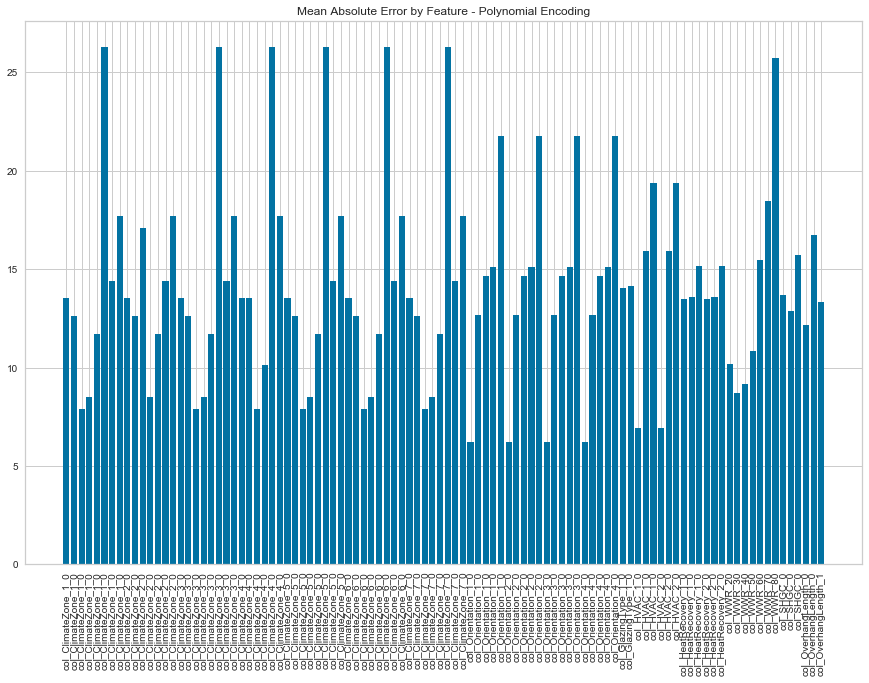

In [32]:
#Polynomial Encoding

#Predict across all dataset
y_pred_poly = grdBoosting_poly.predict(Results_poly)
predictions_poly = pd.DataFrame(y_pred_poly, columns=['Predictions'])
actual = pd.DataFrame(y, columns=['Actual'])
MAE_poly = pd.concat([Results_poly, predictions, actual], axis=1)

#Calculate errors per feature
features = Results_poly.columns
error = np.zeros((100,1))
values = np.zeros((100,1)).astype(str)
k = -1
for feature in features:
    j=-1
    for value in Results_poly[feature].unique():
        k+=1
        j+=1
        error[(k)] = mean_absolute_error(MAE_poly.loc[MAE_poly[feature] == value]['Actual'], 
                                           MAE_poly.loc[MAE_poly[feature] == value]['Predictions'])
        values[(k)] = feature + '_' + str(int(MAE_poly[feature].unique()[j]))


# Plot MAE for each feature
plt.figure(figsize=(15,10))
plt.title("Mean Absolute Error by Feature - Polynomial Encoding")
plt.bar(range(values.shape[0]), error.ravel())
plt.xticks(range(values.shape[0]), values.ravel(), rotation=90)
plt.savefig('ErrorPerFeature_poly')
plt.show()

#### Calculate Mean Absolute Error of feature and feature values, for the stacked model

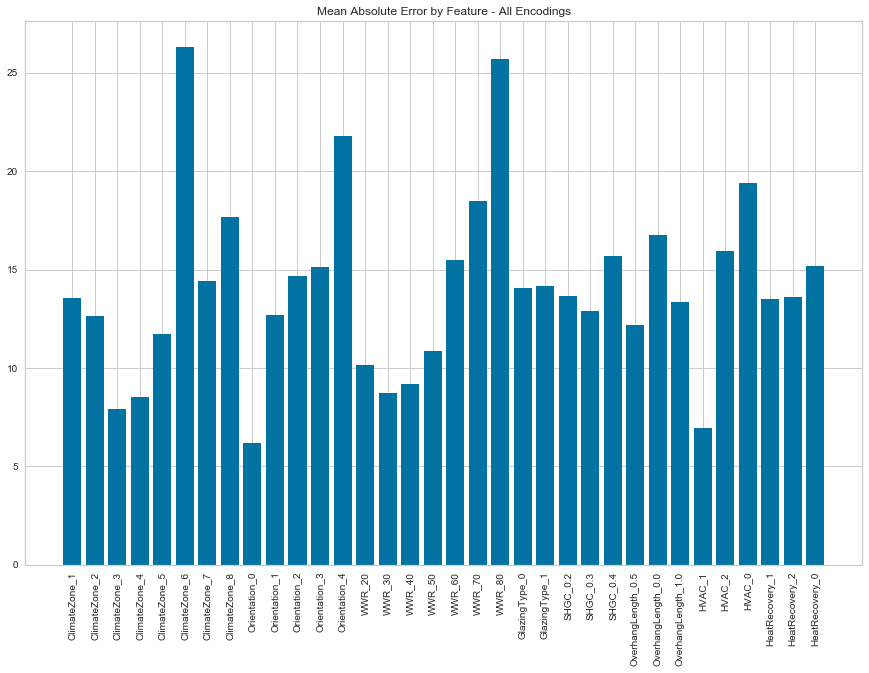

In [34]:
#ALL Encodings
features = Results_GBM.columns[:8]
error = np.zeros((34,1))
values = np.zeros((34,1)).astype(str)
k = -1
for feature in features:
    j=-1
    for value in Results_GBM[feature].unique():
        k+=1
        j+=1
        error[(k)] = mean_absolute_error(Results_GBM.loc[Results_GBM[feature] == value]['Actual'], 
                                           Results_GBM.loc[Results_GBM[feature] == value]['Predictions'])
        values[(k)] = feature + '_' + str(Results_GBM[feature].unique()[j])


# Plot MAE for each feature
plt.figure(figsize=(15,10))
plt.title("Mean Absolute Error by Feature - All Encodings")
plt.bar(range(values.shape[0]), error.ravel())
plt.xticks(range(values.shape[0]), values.ravel(), rotation=90)
plt.savefig('ErrorPerFeature_all')
plt.show()

#### Calculate feature importances for all encodings

Note: this can take a while to calculate.

Note to self: There is probably a more efficient way to do it

##### Sum Encoding

Feature ranking:
1. feature 16 (0.194072)
2. feature 17 (0.115301)
3. feature 18 (0.106511)
4. feature 11 (0.088139)
5. feature 12 (0.061770)
6. feature 13 (0.060138)
7. feature 14 (0.053510)
8. feature 15 (0.049947)
9. feature 9 (0.037007)
10. feature 10 (0.036975)
11. feature 5 (0.036195)
12. feature 8 (0.032269)
13. feature 7 (0.027897)
14. feature 6 (0.022310)
15. feature 0 (0.019054)
16. feature 1 (0.017249)
17. feature 4 (0.016110)
18. feature 3 (0.013039)
19. feature 2 (0.012506)


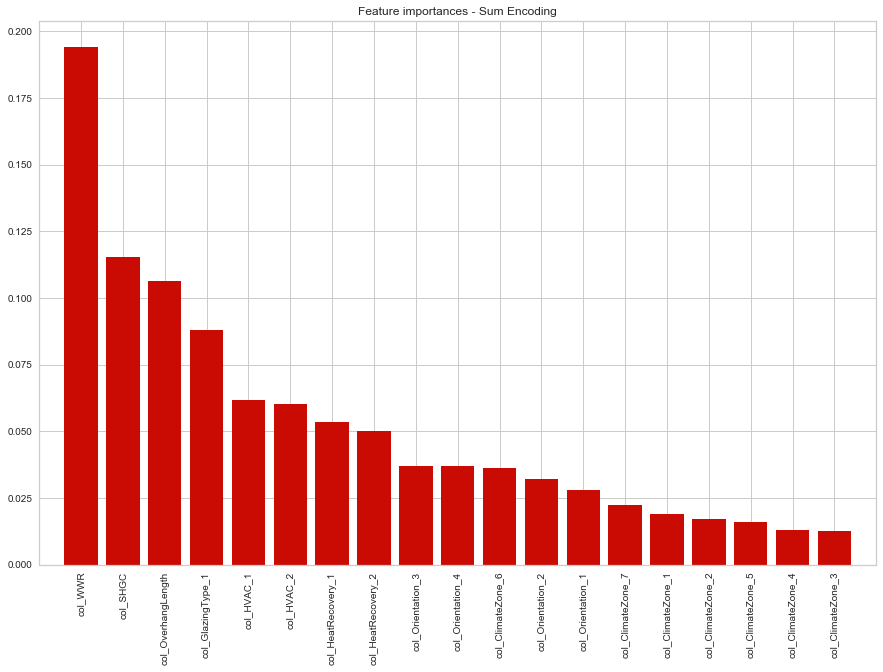

In [29]:
#Calculate, rank, and plot feature importance - Sum encoding
importances_sum = grdBoosting_sum.feature_importances_
std_sum = np.std([grdBoosting_sum.feature_importances_ for estimator in grdBoosting_sum.estimators_],
             axis=0)
indices_sum = np.argsort(importances_sum)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Results_sum.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices_sum[f], importances_sum[indices_sum[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances - Sum Encoding")
plt.bar(range(Results_sum.shape[1]), importances_sum[indices_sum], label=importances_sum[indices_sum],
       color="r", yerr=std_sum[indices_sum], align="center")
plt.xticks(range(Results_sum.shape[1]), Results_sum.columns[indices_sum], rotation=90)
plt.xlim([-1, Results_sum.shape[1]])
plt.savefig('FeatureImportance_sum')
plt.show()

##### Backward Differencing Encoding

Feature ranking:
1. feature 16 (0.172305)
2. feature 18 (0.091355)
3. feature 17 (0.085656)
4. feature 11 (0.072565)
5. feature 13 (0.065494)
6. feature 12 (0.059142)
7. feature 15 (0.051832)
8. feature 9 (0.049236)
9. feature 14 (0.045189)
10. feature 8 (0.044149)
11. feature 10 (0.043970)
12. feature 4 (0.042118)
13. feature 5 (0.036249)
14. feature 3 (0.029916)
15. feature 7 (0.026140)
16. feature 1 (0.022741)
17. feature 2 (0.022055)
18. feature 0 (0.020381)
19. feature 6 (0.019509)


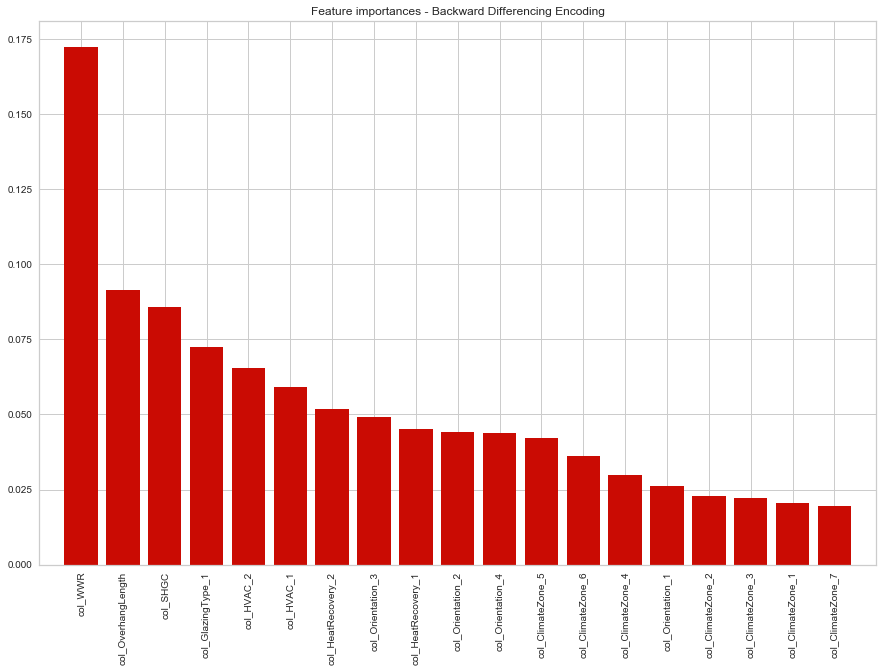

In [30]:
#Calculate, rank, and plot feature importance - Backward Differencing encoding
importances_bd = grdBoosting_bd.feature_importances_
std_bd = np.std([grdBoosting_bd.feature_importances_ for estimator in grdBoosting_bd.estimators_],
             axis=0)
indices_bd = np.argsort(importances_bd)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Results_bd.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices_bd[f], importances_bd[indices_bd[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances - Backward Differencing Encoding")
plt.bar(range(Results_bd.shape[1]), importances_bd[indices_bd], label=importances_bd[indices_bd],
       color="r", yerr=std_bd[indices_bd], align="center")
plt.xticks(range(Results_bd.shape[1]), Results_bd.columns[indices_bd], rotation=90)
plt.xlim([-1, Results_bd.shape[1]])
plt.savefig('FeatureImportance_bd')
plt.show()

##### Binary Encoding

Feature ranking:
1. feature 11 (0.162179)
2. feature 12 (0.090284)
3. feature 13 (0.089402)
4. feature 0 (0.082972)
5. feature 2 (0.080017)
6. feature 1 (0.079122)
7. feature 6 (0.066384)
8. feature 4 (0.059738)
9. feature 5 (0.057823)
10. feature 7 (0.052944)
11. feature 9 (0.050540)
12. feature 8 (0.048588)
13. feature 10 (0.047927)
14. feature 3 (0.032079)


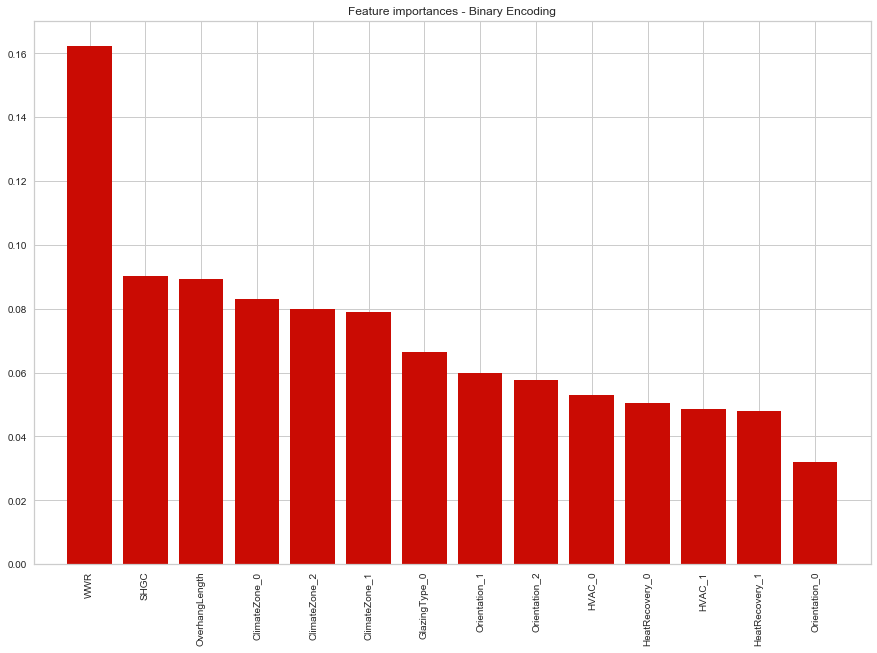

In [31]:
#Calculate, rank, and plot feature importance - Binary Differencing encoding
importances_bin = grdBoosting_bin.feature_importances_
std_bin = np.std([grdBoosting_bin.feature_importances_ for estimator in grdBoosting_bin.estimators_],
             axis=0)
indices_bin = np.argsort(importances_bin)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Results_bin.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices_bin[f], importances_bin[indices_bin[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances - Binary Encoding")
plt.bar(range(Results_bin.shape[1]), importances_bin[indices_bin], label=importances_bin[indices_bin],
       color="r", yerr=std_bin[indices_bin], align="center")
plt.xticks(range(Results_bin.shape[1]), Results_bin.columns[indices_bin], rotation=90)
plt.xlim([-1, Results_bin.shape[1]])
plt.savefig('FeatureImportance_bin')
plt.show()

##### One Hot Encoding

Feature ranking:
1. feature 21 (0.196417)
2. feature 22 (0.118809)
3. feature 23 (0.107481)
4. feature 17 (0.047329)
5. feature 13 (0.042945)
6. feature 14 (0.042936)
7. feature 15 (0.037239)
8. feature 16 (0.036554)
9. feature 18 (0.034494)
10. feature 12 (0.034183)
11. feature 20 (0.034183)
12. feature 19 (0.032534)
13. feature 5 (0.030362)
14. feature 11 (0.028828)
15. feature 10 (0.026310)
16. feature 9 (0.022345)
17. feature 6 (0.020464)
18. feature 0 (0.020073)
19. feature 8 (0.019812)
20. feature 7 (0.018336)
21. feature 1 (0.015109)
22. feature 4 (0.011990)
23. feature 3 (0.011536)
24. feature 2 (0.009732)


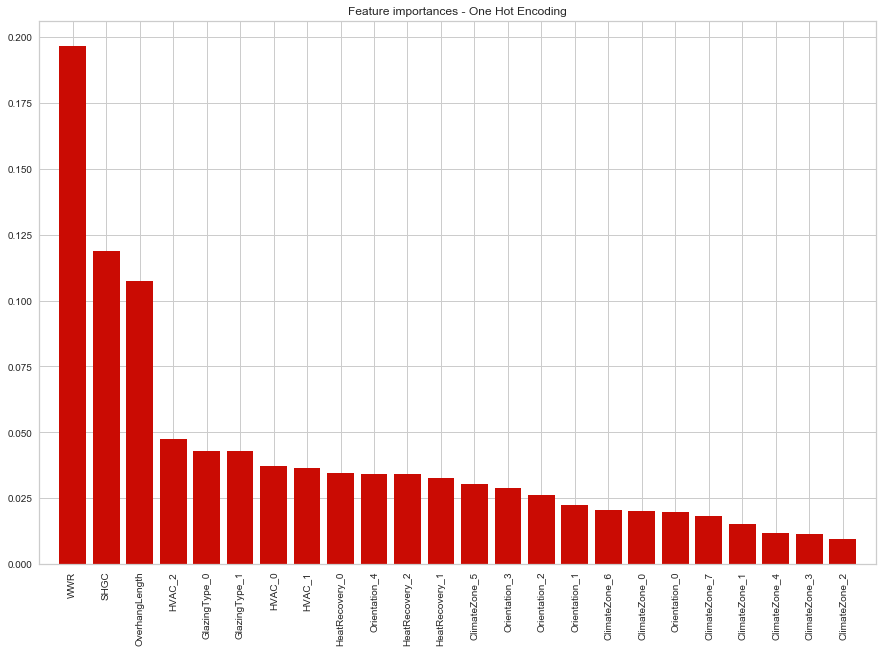

In [32]:
#Calculate, rank, and plot feature importance - One Hot encoding
importances_onh = grdBoosting_onh.feature_importances_
std_onh = np.std([grdBoosting_onh.feature_importances_ for estimator in grdBoosting_onh.estimators_],
             axis=0)
indices_onh = np.argsort(importances_onh)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Results_onh.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices_onh[f], importances_onh[indices_onh[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances - One Hot Encoding")
plt.bar(range(Results_onh.shape[1]), importances_onh[indices_onh], label=importances_onh[indices_onh],
       color="r", yerr=std_onh[indices_onh], align="center")
plt.xticks(range(Results_onh.shape[1]), Results_onh.columns[indices_onh], rotation=90)
plt.xlim([-1, Results_onh.shape[1]])
plt.savefig('FeatureImportance_onh')
plt.show()

##### Ordinal Encoding

Feature ranking:
1. feature 3 (0.184367)
2. feature 0 (0.170967)
3. feature 4 (0.159154)
4. feature 6 (0.116427)
5. feature 1 (0.102542)
6. feature 7 (0.098400)
7. feature 2 (0.086527)
8. feature 5 (0.081616)


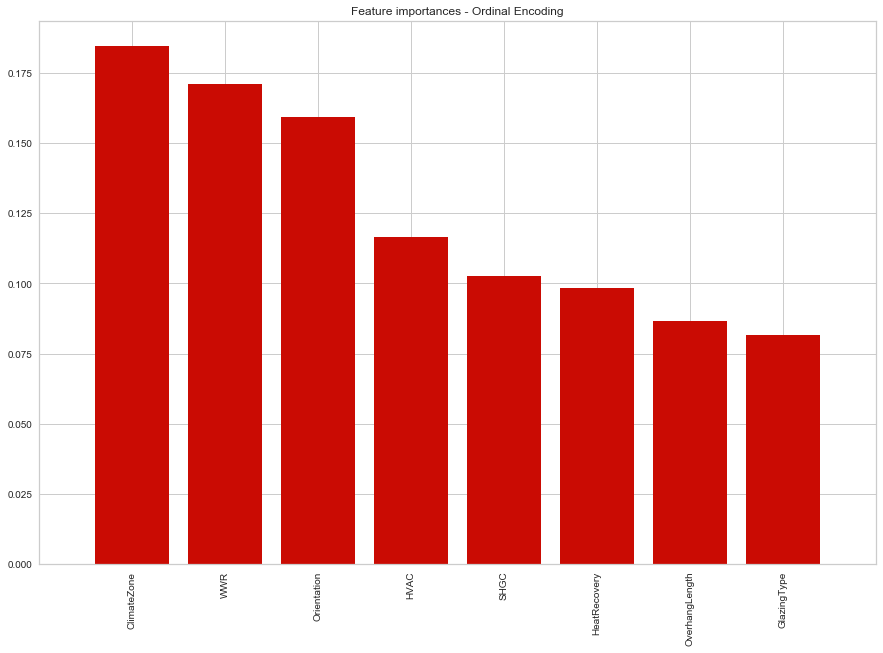

In [33]:
#Calculate, rank, and plot feature importance - Ordinal encoding
importances_ord = grdBoosting_ord.feature_importances_
std_ord = np.std([grdBoosting_ord.feature_importances_ for estimator in grdBoosting_ord.estimators_],
             axis=0)
indices_ord = np.argsort(importances_ord)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Results_ord.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices_ord[f], importances_ord[indices_ord[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances - Ordinal Encoding")
plt.bar(range(Results_ord.shape[1]), importances_ord[indices_ord], label=importances_ord[indices_ord],
       color="r", yerr=std_ord[indices_ord], align="center")
plt.xticks(range(Results_ord.shape[1]), Results_ord.columns[indices_ord], rotation=90)
plt.xlim([-1, Results_ord.shape[1]])
plt.savefig('FeatureImportance_ord')
plt.show()

##### Leave One Out Encoding

Feature ranking:
1. feature 3 (0.193809)
2. feature 0 (0.169521)
3. feature 4 (0.162397)
4. feature 6 (0.130534)
5. feature 1 (0.094500)
6. feature 7 (0.089008)
7. feature 2 (0.087155)
8. feature 5 (0.073076)


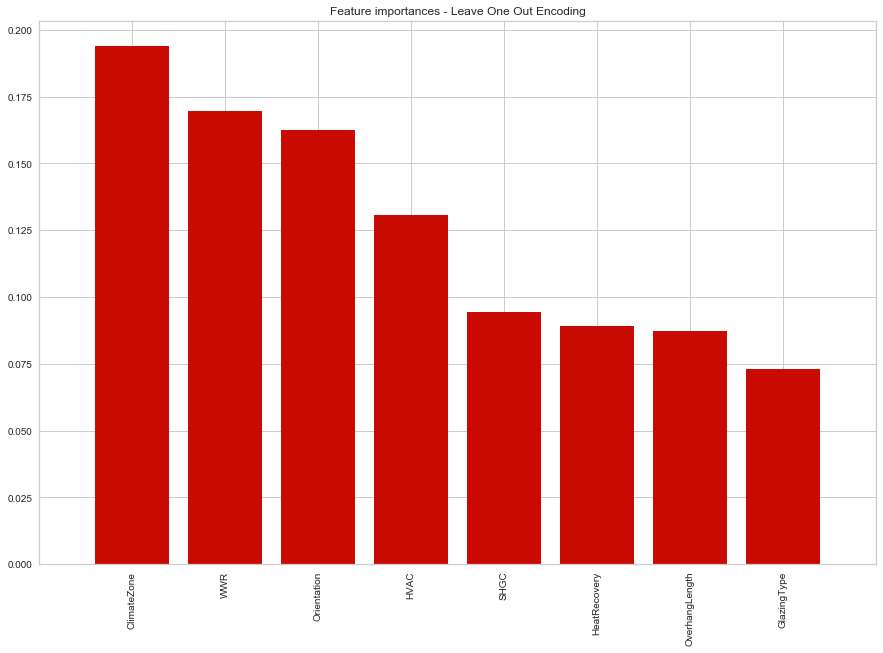

In [34]:
#Calculate, rank, and plot feature importance - Leave One Out encoding
importances_lou = grdBoosting_lou.feature_importances_
std_lou = np.std([grdBoosting_lou.feature_importances_ for estimator in grdBoosting_lou.estimators_],
             axis=0)
indices_lou = np.argsort(importances_lou)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Results_lou.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices_lou[f], importances_lou[indices_lou[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances - Leave One Out Encoding")
plt.bar(range(Results_lou.shape[1]), importances_lou[indices_lou], label=importances_lou[indices_lou],
       color="r", yerr=std_lou[indices_lou], align="center")
plt.xticks(range(Results_lou.shape[1]), Results_lou.columns[indices_lou], rotation=90)
plt.xlim([-1, Results_lou.shape[1]])
plt.savefig('FeatureImportance_lou')
plt.show()

##### Polynomial Encoding

Feature ranking:
1. feature 16 (0.196901)
2. feature 17 (0.113352)
3. feature 18 (0.103356)
4. feature 11 (0.080902)
5. feature 12 (0.071949)
6. feature 14 (0.062353)
7. feature 7 (0.048986)
8. feature 9 (0.044064)
9. feature 13 (0.037216)
10. feature 0 (0.033025)
11. feature 2 (0.031233)
12. feature 15 (0.029851)
13. feature 4 (0.028238)
14. feature 6 (0.027104)
15. feature 8 (0.022374)
16. feature 10 (0.022141)
17. feature 1 (0.016174)
18. feature 5 (0.016075)
19. feature 3 (0.014708)


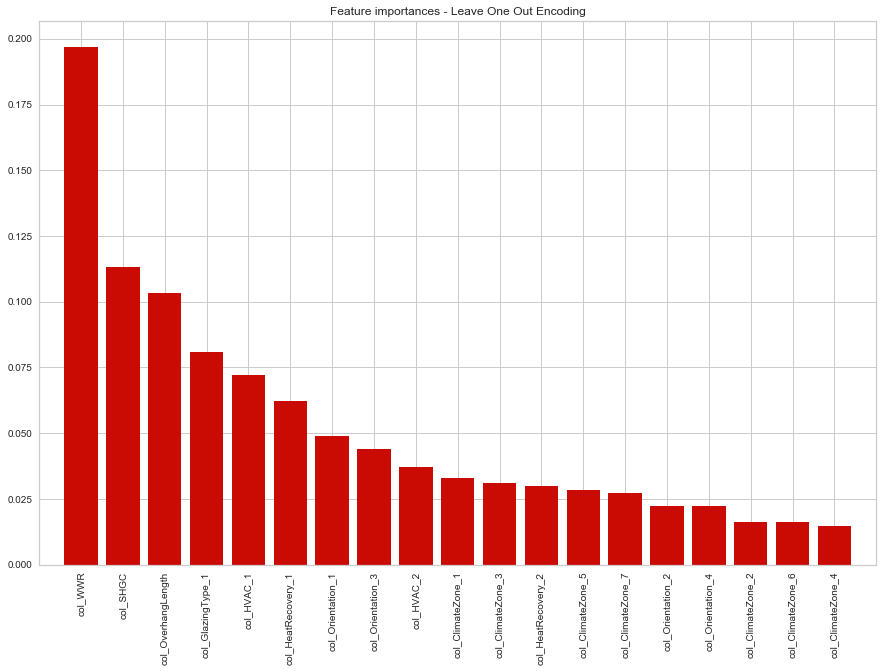

In [35]:
#Calculate, rank, and plot feature importance - Polynomial encoding
importances_poly = grdBoosting_poly.feature_importances_
std_poly = np.std([grdBoosting_poly.feature_importances_ for estimator in grdBoosting_poly.estimators_],
             axis=0)
indices_poly = np.argsort(importances_poly)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Results_poly.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices_poly[f], importances_poly[indices_poly[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances - Leave One Out Encoding")
plt.bar(range(Results_poly.shape[1]), importances_poly[indices_poly], label=importances_poly[indices_poly],
       color="r", yerr=std_poly[indices_poly], align="center")
plt.xticks(range(Results_poly.shape[1]), Results_poly.columns[indices_poly], rotation=90)
plt.xlim([-1, Results_poly.shape[1]])
plt.savefig('FeatureImportance_poly')
plt.show()